In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-04-26 10:06:50.723285: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-26 10:06:53.079289: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 10:06:53.079313: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 10:06:53.079761: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-26 10:06:53.135918: I tensorflow/core/platform/cpu_feature_g

Num GPUs Available:  1


In [1]:

import sys
import os
## Imports ##
src = "/Users/rp/Desktop/Research/CN^3/Thesis Material/2-Region-Latent-Alignment/src"
if src not in sys.path:
    sys.path.append(src)


print(sys.path)
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
# from pi_vae.pi_vae import *
from pi_vae.vae import *
from pi_vae.util import *
from modeling.vae_model import *
from utils.data_processing import *
from utils.plotting import *
from utils.model_utils import *

def poisson_deviance(y_true, y_pred):
    # Ensure the prediction is positive to avoid log of zero or negative
    y_pred = np.maximum(y_pred, 1e-9)
    # Ensure true values are positive to avoid log of zero (log(0) is undefined)
    y_true = np.maximum(y_true, 1e-9)
    
    # Calculate the Poisson deviance
    deviance = 2 * (y_true * (np.log(y_true) - np.log(y_pred)) - (y_true - y_pred))
    return np.sum(deviance)

def reconstruct_and_evaluate(vae, x_test, u_test, model_chk_path):
    outputs_test = inference(vae, x_test, u_test, model_chk_path)

    # Assuming the reconstruction is the fourth output of the model
    reconstructed_x = outputs_test[3]
    
    # Flatten the first two dimensions of x_test and reconstructed_x
    x_test_flat = x_test.reshape(-1, x_test.shape[-1])
    reconstructed_x_flat = reconstructed_x.reshape(-1, reconstructed_x.shape[-1])
    
    # Compute R2 and MSE metrics
    r2 = r2_score(x_test_flat, reconstructed_x_flat, multioutput='variance_weighted')
    mse = mean_squared_error(x_test_flat, reconstructed_x_flat)
    
    # Compute Poisson deviance
    deviance = poisson_deviance(x_test_flat, reconstructed_x_flat)
    
    return reconstructed_x, r2, mse, deviance

def evaluate_model(vae, x_test, u_test, model_chk_path):
    reconstructed_x, r2, mse, deviance = reconstruct_and_evaluate(vae, x_test, u_test, model_chk_path)
    return r2, mse, deviance
    
def main(version, random_seed, brain_region, ecephys_session_id, model_type, training, behavior_vars=['frame']):
    results_path = f'hyperparam_search_results_male_{brain_region}_{"_".join(behavior_vars)}.csv'
    headers_should_be_written = not os.path.exists(results_path)

    for latent_dim in range(10, 13):  # From 6 to 20
        spike_count_pivot, behavior_data_df = extract_data(ecephys_session_id, brain_region)
        x_all, u_all = transform_data(spike_count_pivot, behavior_data_df, behavior_vars)
        x_train, u_train, x_valid, u_valid, x_test, u_test = load_data(x_all=x_all, u_all=u_all)
        model_chk_path, workflow_name = get_model_paths(ecephys_session_id, brain_region, behavior_vars, latent_dim, random_seed, model_type)

        vae = initialize_model(dim_x=x_all[0].shape[-1], dim_z=latent_dim,
                               dim_u=u_all[0].shape[-1], gen_nodes=60, n_blk=2, mdl='poisson',
                               disc=False, learning_rate=5e-4, random_seed=random_seed)

        if training:
            s_n = train_model(vae, x_train, u_train, x_valid, u_valid, model_chk_path)
            last_val_loss = s_n.history['val_loss'][-1]
            plot_validation_loss(s_n, workflow_name, version, save_plot=True, show_plot=False)

        r2, mse, deviance = evaluate_model(vae, x_test, u_test, model_chk_path)
        new_row = pd.DataFrame({'Version': version, 'Latent_Dim': latent_dim, 'Random_Seed': random_seed,
                                        'Brain_Region': brain_region, 'Model_Type': model_type, 'R2': r2, 'MSE': mse,
                                        'Poisson_Deviance': deviance, 'Last_Val_Loss': last_val_loss}, index=[0])
        
        if headers_should_be_written:
            new_row.to_csv(results_path, mode='a', index=False, header=True)
            headers_should_be_written = False
        else:
            new_row.to_csv(results_path, mode='a', index=False, header=False)
    
    plot_results(results_path, f'evaluation_metrics_plots_male_{brain_region}_{model_type}')

def plot_results(results_path, plot_name='evaluation_metrics_plots_male_CA1'):
    results = pd.read_csv(results_path)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    metrics = ['R2', 'MSE', 'Poisson_Deviance', 'Last_Val_Loss']
    for ax, metric in zip(axes.flatten(), metrics):
        for key, grp in results.groupby(['Brain_Region', 'Model_Type']):
            ax.plot(grp['Latent_Dim'], grp[metric], label=f"{key} {metric}")
        ax.set_xlabel('Latent Dimension')
        ax.set_ylabel(metric)
        ax.set_title(f'Plot of {metric} by Latent Dimension')
        ax.legend()
    plt.tight_layout()
    plt.savefig(f'{plot_name}.png')
    plt.show()

if __name__ == "__main__":
    VERSION = 1
    RANDOM_SEED = 999
    BRAIN_REGIONS = ['CA1', 'VISp']
    MODEL_TYPES = ['vae', 'pivae']
    TRAINING = True
    ecephys_session_id = 771160300
    brain_region = BRAIN_REGIONS[0]
    model_type = MODEL_TYPES[0]

    main(VERSION, RANDOM_SEED, brain_region, ecephys_session_id, model_type, TRAINING, ['position'])


['/Users/rp/Desktop/Research/CN^3/Thesis Material/2-Region-Latent-Alignment/src/notebooks/modeling/Decoding', '/usr/local/anaconda3/envs/cn3/lib/python311.zip', '/usr/local/anaconda3/envs/cn3/lib/python3.11', '/usr/local/anaconda3/envs/cn3/lib/python3.11/lib-dynload', '', '/usr/local/anaconda3/envs/cn3/lib/python3.11/site-packages', '/Users/rp/Desktop/Research/CN^3/Thesis Material/2-Region-Latent-Alignment/src']


2024-04-26 13:17:24.938334: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'vae_mdl' is not defined

NameError: name 'u_train' is not defined

(48, 900, 1)


Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 82)]                 0         []                            
                                                                                                  
 input_27 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 encoder (Functional)        [(None, 10),                 18520     ['input_25[0][0]',            
                              (None, 10),                            'input_27[0][0]']            
                              (None, 10),                                                         
                              (None, 10),                                                       

/Users/rp/Desktop/Research/CN^3/Thesis Material/2-Region-Latent-Alignment/src/modeling/vae_model.py:62: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  s_n = vae.fit_generator(custom_data_generator(x_train, u_train),


None hey
Epoch 1/50
48/48 [==============================] - 8s 60ms/step - loss: 54.3189 - val_loss: 40.4792
Epoch 2/50
48/48 [==============================] - 2s 39ms/step - loss: 37.9588 - val_loss: 37.0187
Epoch 3/50
48/48 [==============================] - 1s 26ms/step - loss: 36.6142 - val_loss: 36.4413
Epoch 4/50
48/48 [==============================] - 1s 27ms/step - loss: 36.1474 - val_loss: 35.9262
Epoch 5/50
48/48 [==============================] - 1s 27ms/step - loss: 35.5825 - val_loss: 35.3828
Epoch 6/50
48/48 [==============================] - 1s 27ms/step - loss: 35.0640 - val_loss: 35.0867
Epoch 7/50
48/48 [==============================] - 1s 25ms/step - loss: 34.7964 - val_loss: 34.9252
Epoch 8/50
48/48 [==============================] - 1s 25ms/step - loss: 34.6364 - val_loss: 34.8253
Epoch 9/50
48/48 [==============================] - 1s 26ms/step - loss: 34.5018 - val_loss: 34.7009
Epoch 10/50
48/48 [==============================] - 1s 31ms/step - loss: 34.3858 

/Users/rp/Desktop/Research/CN^3/Thesis Material/2-Region-Latent-Alignment/src/utils/plotting.py:242: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{plot_dir}/{workflow_name}_val_loss.png", dpi=300)
/Users/rp/Desktop/Research/CN^3/Thesis Material/2-Region-Latent-Alignment/src/utils/plotting.py:242: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{plot_dir}/{workflow_name}_val_loss.png", dpi=300)
/Users/rp/Desktop/Research/CN^3/Thesis Material/2-Region-Latent-Alignment/src/utils/plotting.py:242: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{plot_dir}/{workflow_name}

(48, 900, 1)


Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_28 (InputLayer)       [(None, 82)]                 0         []                            
                                                                                                  
 input_30 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 encoder (Functional)        [(None, 11),                 18644     ['input_28[0][0]',            
                              (None, 11),                            'input_30[0][0]']            
                              (None, 11),                                                         
                              (None, 11),                                                       

/Users/rp/Desktop/Research/CN^3/Thesis Material/2-Region-Latent-Alignment/src/modeling/vae_model.py:62: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  s_n = vae.fit_generator(custom_data_generator(x_train, u_train),


48/48 [==============================] - 8s 33ms/step - loss: 52.5066 - val_loss: 39.7413
Epoch 2/50
48/48 [==============================] - 1s 28ms/step - loss: 37.6377 - val_loss: 36.7788
Epoch 3/50
48/48 [==============================] - 1s 25ms/step - loss: 36.5937 - val_loss: 36.3492
Epoch 4/50
48/48 [==============================] - 1s 29ms/step - loss: 36.1982 - val_loss: 36.0540
Epoch 5/50
48/48 [==============================] - 2s 32ms/step - loss: 35.7969 - val_loss: 35.5823
Epoch 6/50
48/48 [==============================] - 1s 31ms/step - loss: 35.3321 - val_loss: 35.2368
Epoch 7/50
48/48 [==============================] - 2s 36ms/step - loss: 34.9595 - val_loss: 34.9370
Epoch 8/50
48/48 [==============================] - 2s 35ms/step - loss: 34.6617 - val_loss: 34.7440
Epoch 9/50
48/48 [==============================] - 2s 43ms/step - loss: 34.4787 - val_loss: 34.6104
Epoch 10/50
48/48 [==============================] - 2s 46ms/step - loss: 34.3473 - val_loss: 34.5483


/Users/rp/Desktop/Research/CN^3/Thesis Material/2-Region-Latent-Alignment/src/utils/plotting.py:242: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{plot_dir}/{workflow_name}_val_loss.png", dpi=300)
/Users/rp/Desktop/Research/CN^3/Thesis Material/2-Region-Latent-Alignment/src/utils/plotting.py:242: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{plot_dir}/{workflow_name}_val_loss.png", dpi=300)
/Users/rp/Desktop/Research/CN^3/Thesis Material/2-Region-Latent-Alignment/src/utils/plotting.py:242: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{plot_dir}/{workflow_name}

(48, 900, 1)


Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 82)]                 0         []                            
                                                                                                  
 input_33 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 encoder (Functional)        [(None, 12),                 18768     ['input_31[0][0]',            
                              (None, 12),                            'input_33[0][0]']            
                              (None, 12),                                                         
                              (None, 12),                                                       

/Users/rp/Desktop/Research/CN^3/Thesis Material/2-Region-Latent-Alignment/src/modeling/vae_model.py:62: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  s_n = vae.fit_generator(custom_data_generator(x_train, u_train),


48/48 [==============================] - 7s 35ms/step - loss: 52.8331 - val_loss: 40.1566
Epoch 2/50
48/48 [==============================] - 1s 26ms/step - loss: 37.8104 - val_loss: 36.9779
Epoch 3/50
48/48 [==============================] - 1s 27ms/step - loss: 36.6783 - val_loss: 36.4925
Epoch 4/50
48/48 [==============================] - 1s 27ms/step - loss: 36.2789 - val_loss: 36.0677
Epoch 5/50
48/48 [==============================] - 1s 29ms/step - loss: 35.7665 - val_loss: 35.6851
Epoch 6/50
48/48 [==============================] - 2s 32ms/step - loss: 35.2963 - val_loss: 35.2866
Epoch 7/50
48/48 [==============================] - 2s 34ms/step - loss: 34.8751 - val_loss: 35.0026
Epoch 8/50
48/48 [==============================] - 1s 24ms/step - loss: 34.6168 - val_loss: 34.8036
Epoch 9/50
48/48 [==============================] - 1s 23ms/step - loss: 34.4612 - val_loss: 34.7216
Epoch 10/50
48/48 [==============================] - 1s 25ms/step - loss: 34.3515 - val_loss: 34.6194


/Users/rp/Desktop/Research/CN^3/Thesis Material/2-Region-Latent-Alignment/src/utils/plotting.py:242: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{plot_dir}/{workflow_name}_val_loss.png", dpi=300)
/Users/rp/Desktop/Research/CN^3/Thesis Material/2-Region-Latent-Alignment/src/utils/plotting.py:242: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{plot_dir}/{workflow_name}_val_loss.png", dpi=300)
/Users/rp/Desktop/Research/CN^3/Thesis Material/2-Region-Latent-Alignment/src/utils/plotting.py:242: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{plot_dir}/{workflow_name}

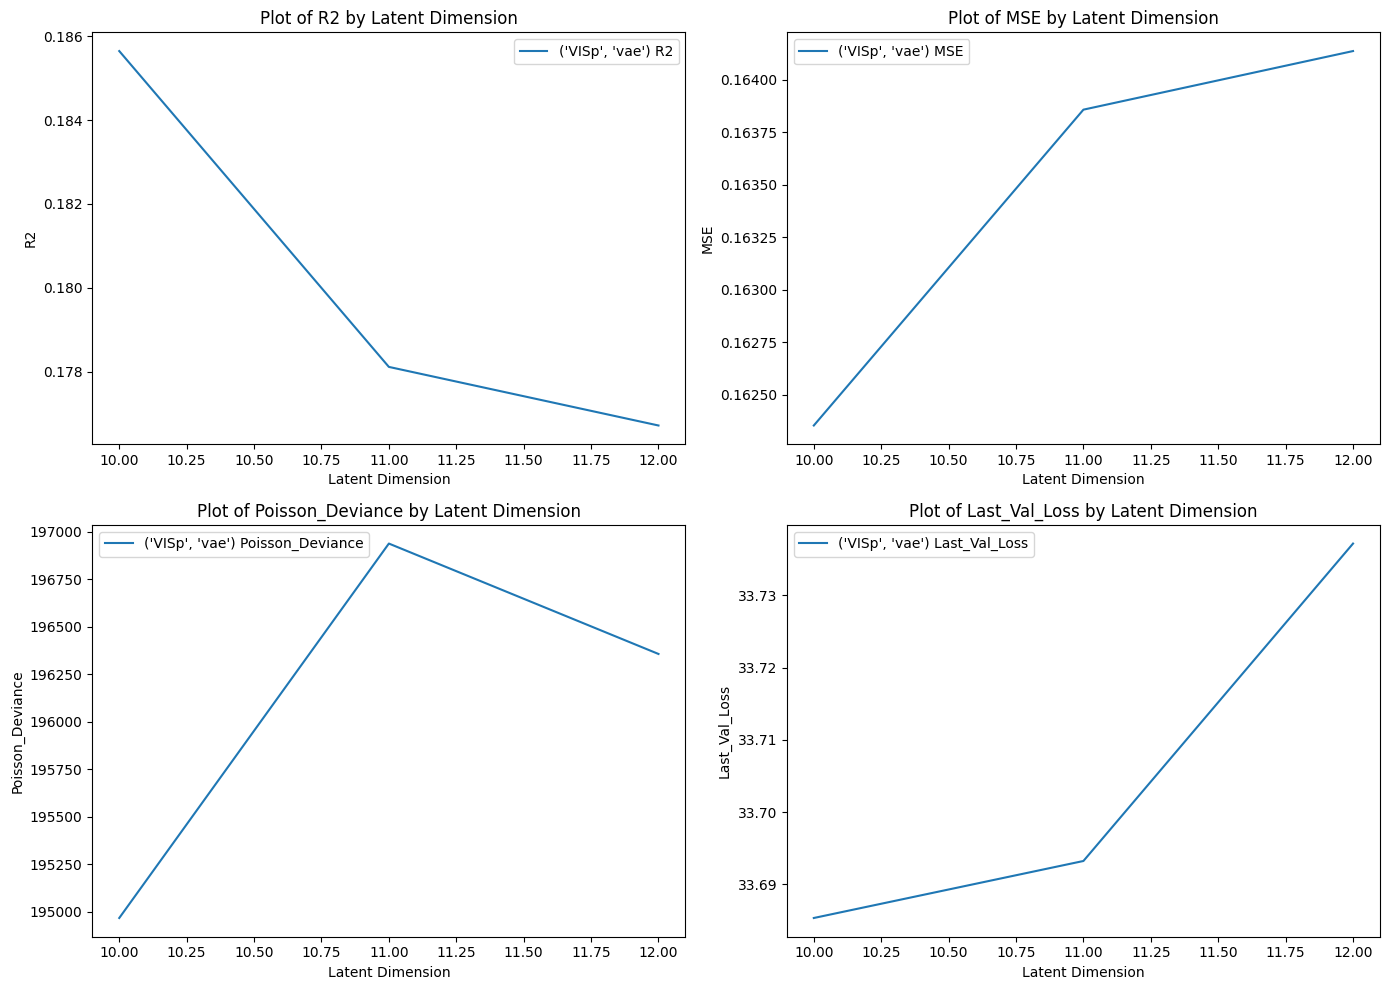

In [7]:

import sys
import os
## Imports ##
src = "/Users/rp/Desktop/Research/CN^3/Thesis Material/2-Region-Latent-Alignment/src"
if src not in sys.path:
    sys.path.append(src)

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
from pi_vae.vae import *
from pi_vae.util import *
from modeling.vae_model import *
from utils.data_processing import *
from utils.plotting import *
from utils.model_utils import *

def poisson_deviance(y_true, y_pred):
    # Ensure the prediction is positive to avoid log of zero or negative
    y_pred = np.maximum(y_pred, 1e-9)
    # Ensure true values are positive to avoid log of zero (log(0) is undefined)
    y_true = np.maximum(y_true, 1e-9)
    
    # Calculate the Poisson deviance
    deviance = 2 * (y_true * (np.log(y_true) - np.log(y_pred)) - (y_true - y_pred))
    return np.sum(deviance)

def reconstruct_and_evaluate(vae, x_test, u_test, model_chk_path):
    outputs_test = inference(vae, x_test, u_test, model_chk_path)

    # Assuming the reconstruction is the fourth output of the model
    reconstructed_x = outputs_test[3]
    
    # Flatten the first two dimensions of x_test and reconstructed_x
    x_test_flat = x_test.reshape(-1, x_test.shape[-1])
    reconstructed_x_flat = reconstructed_x.reshape(-1, reconstructed_x.shape[-1])
    
    # Compute R2 and MSE metrics
    r2 = r2_score(x_test_flat, reconstructed_x_flat, multioutput='variance_weighted')
    mse = mean_squared_error(x_test_flat, reconstructed_x_flat)
    
    # Compute Poisson deviance
    deviance = poisson_deviance(x_test_flat, reconstructed_x_flat)
    
    return reconstructed_x, r2, mse, deviance

def evaluate_model(vae, x_test, u_test, model_chk_path):
    reconstructed_x, r2, mse, deviance = reconstruct_and_evaluate(vae, x_test, u_test, model_chk_path)
    return r2, mse, deviance
    
def main(version, random_seed, brain_region, ecephys_session_id, model_type, training, behavior_vars=['frame']):
    results_path = f'hyperparam_search_results_male_{brain_region}_{"_".join(behavior_vars)}.csv'
    headers_should_be_written = not os.path.exists(results_path)

    for latent_dim in range(10, 13):  # From 6 to 20
        spike_count_pivot, behavior_data_df = extract_data(ecephys_session_id, brain_region)
        x_all, u_all = transform_data(spike_count_pivot, behavior_data_df, behavior_vars)
        x_train, u_train, x_valid, u_valid, x_test, u_test = load_data(x_all=x_all, u_all=u_all)
        print(u_train.shape)
        model_chk_path, workflow_name = get_model_paths(ecephys_session_id, brain_region, behavior_vars, latent_dim, random_seed, model_type)

        vae = vae_mdl(dim_x=x_all[0].shape[-1], 
                   dim_z=latent_dim,
                   gen_nodes=60, n_blk=2, mdl='poisson', learning_rate=5e-4)

        if training:
            s_n = train_model(vae, x_train, np.zeros(u_train.shape), x_valid, np.zeros(u_valid.shape), model_chk_path)
            last_val_loss = s_n.history['val_loss'][-1]
            plot_validation_loss(s_n, workflow_name, version, save_plot=True, show_plot=False)

        r2, mse, deviance = evaluate_model(vae, x_test, u_test, model_chk_path)
        new_row = pd.DataFrame({'Version': version, 'Latent_Dim': latent_dim, 'Random_Seed': random_seed,
                                        'Brain_Region': brain_region, 'Model_Type': model_type, 'R2': r2, 'MSE': mse,
                                        'Poisson_Deviance': deviance, 'Last_Val_Loss': last_val_loss}, index=[0])
        
        if headers_should_be_written:
            new_row.to_csv(results_path, mode='a', index=False, header=True)
            headers_should_be_written = False
        else:
            new_row.to_csv(results_path, mode='a', index=False, header=False)
    
    plot_results(results_path, f'evaluation_metrics_plots_male_{brain_region}_{model_type}')

def plot_results(results_path, plot_name='evaluation_metrics_plots_male_CA1_vae'):
    results = pd.read_csv(results_path)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    metrics = ['R2', 'MSE', 'Poisson_Deviance', 'Last_Val_Loss']
    for ax, metric in zip(axes.flatten(), metrics):
        for key, grp in results.groupby(['Brain_Region', 'Model_Type']):
            ax.plot(grp['Latent_Dim'], grp[metric], label=f"{key} {metric}")
        ax.set_xlabel('Latent Dimension')
        ax.set_ylabel(metric)
        ax.set_title(f'Plot of {metric} by Latent Dimension')
        ax.legend()
    plt.tight_layout()
    plt.savefig(f'{plot_name}.png')
    plt.show()

if __name__ == "__main__":
    VERSION = 1
    RANDOM_SEED = 999
    BRAIN_REGIONS = ['CA1', 'VISp']
    MODEL_TYPES = ['vae', 'pivae']
    TRAINING = True
    ecephys_session_id = 771160300
    brain_region = BRAIN_REGIONS[1]
    model_type = MODEL_TYPES[0]

    main(VERSION, RANDOM_SEED, brain_region, ecephys_session_id, model_type, TRAINING, ['position'])


In [14]:
def plot_results_v2(results, plot_name='evaluation_metrics_plots_male'):
    # results = pd.read_csv(results_path)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    metrics = ['R2', 'MSE', 'Poisson_Deviance', 'Last_Val_Loss']
    for ax, metric in zip(axes.flatten(), metrics):
        for key, grp in results.groupby(['Brain_Region', 'Model_Type']):
            ax.plot(grp['Latent_Dim'], grp[metric], label=f"{key} {metric}")
        ax.set_xlabel('Latent Dimension')
        ax.set_ylabel(metric)
        ax.set_title(f'Plot of {metric} by Latent Dimension')
        ax.legend()
    plt.tight_layout()
    plt.savefig(f'{plot_name}.png')
    plt.show()

In [11]:
results = pd.read_csv('hyperparam_search_results.csv')

# plot_results(results)
results_male = results[28:]

In [16]:
results_male.to_csv('hyperparam_search_results_male.csv', index=False)

In [17]:
results[:28]

,Version,Latent_Dim,Random_Seed,Brain_Region,Model_Type,R2,MSE,Poisson_Deviance,Last_Val_Loss
0,1,6,999,VISp,pivae,0.154626,0.225192,148471.697568,22.616732
1,1,7,999,VISp,pivae,0.136560,0.230004,151225.989334,22.780388
2,1,8,999,VISp,pivae,0.164669,0.222517,146104.023759,22.638916
3,1,9,999,VISp,pivae,0.168073,0.221610,145432.909254,22.617605
4,1,10,999,VISp,pivae,0.149048,0.226678,149452.478809,22.757881
5,1,11,999,VISp,pivae,0.149909,0.226448,148730.402486,22.664251
6,1,12,999,VISp,pivae,0.153694,0.225440,148441.083583,22.650797
7,1,13,999,VISp,pivae,0.151437,0.226041,148416.653506,22.726271
8,1,14,999,VISp,pivae,0.166934,0.221913,145726.199521,22.681368
9,1,15,999,VISp,pivae,0.166627,0.221995,147037.825897,22.603561


In [18]:
results[:28].to_csv('hyperparam_search_results.csv', index=False)

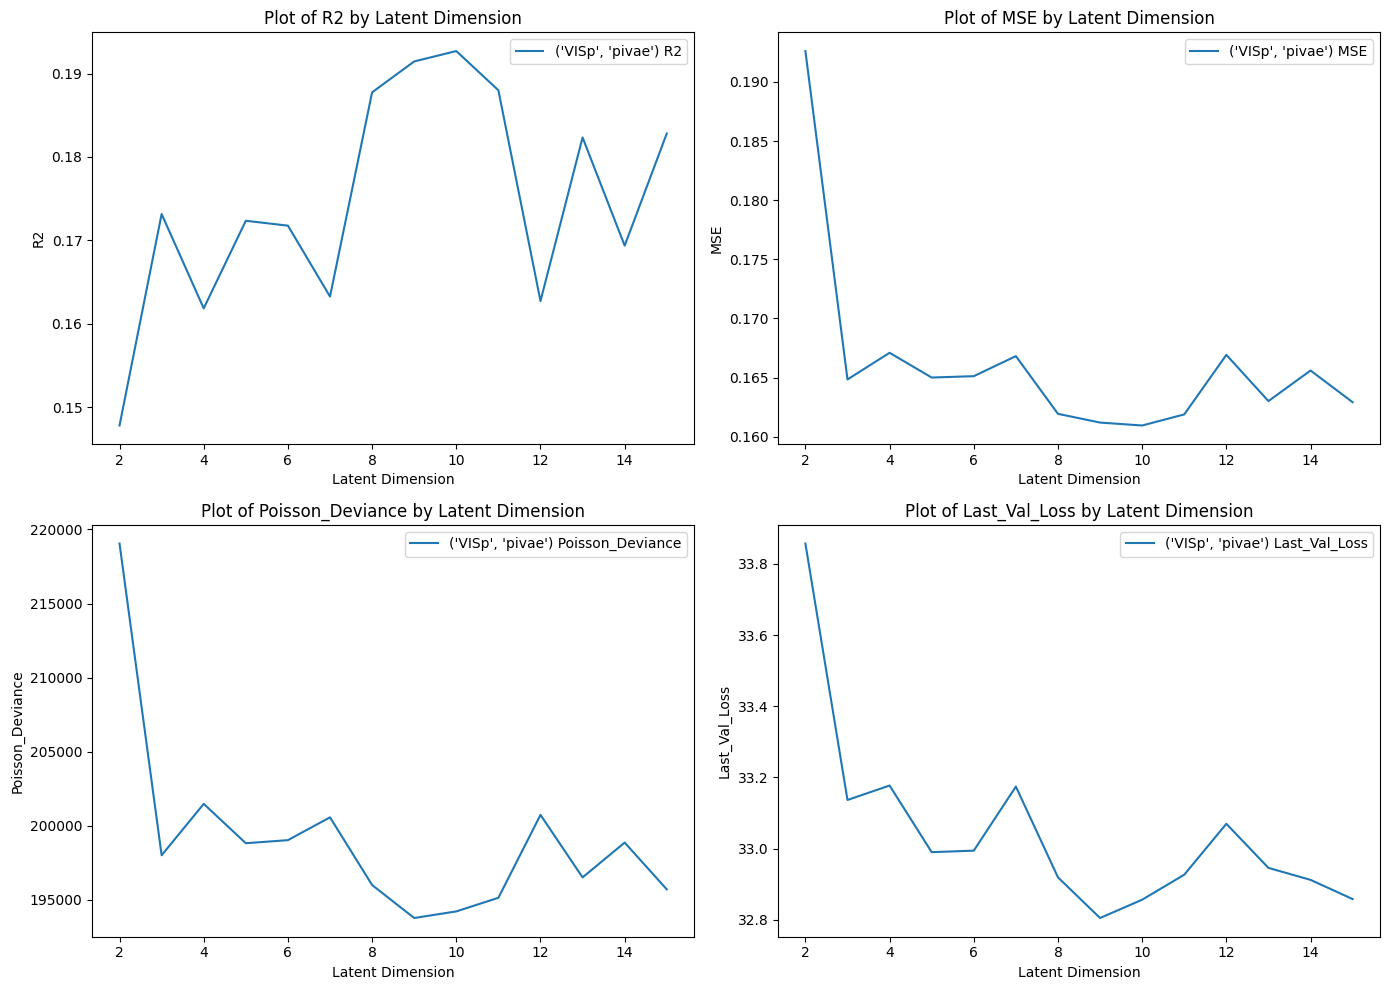

In [15]:
plot_results_v2(results_male)

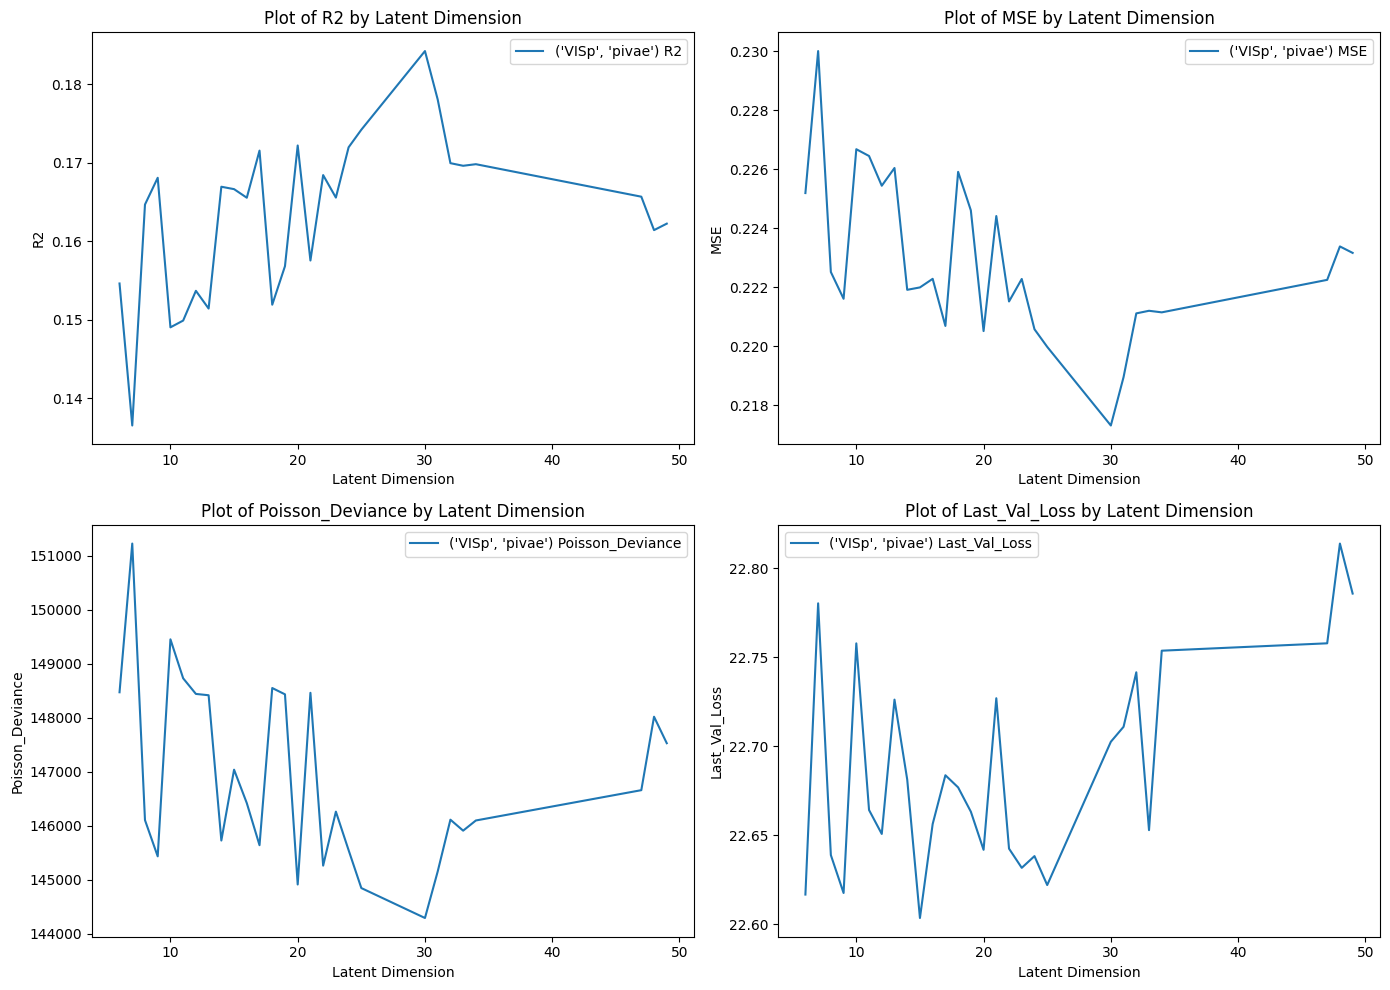

In [7]:
results_path ='hyperparam_search_results.csv'


plot_results(results_path)